<a href="https://colab.research.google.com/github/Jeoml/flowchartparser/blob/main/Roboflow_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded predictions from file


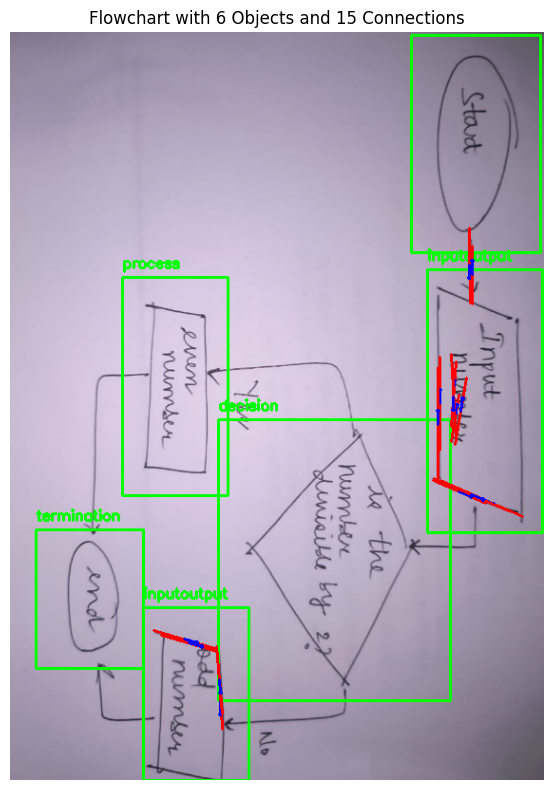

Visualization saved as 'flowchart_with_connections.jpg'
Result saved to 'flowchart_with_connections.json'


In [ ]:
# roboflow integration
import cv2
import numpy as np
import requests
import json
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

# Roboflow API details (replace with your own)
ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
ROBOFLOW_MODEL = "my-first-project-8r5om/2"  # e.g., "flowchart-detection/1"
ROBOFLOW_SIZE = 640  # Size for inference (match your model's training size)

def get_predictions_from_roboflow(image_path):
    """Get object predictions from Roboflow API using multipart/form-data."""
    upload_url = f"https://detect.roboflow.com/{ROBOFLOW_MODEL}?api_key={ROBOFLOW_API_KEY}"

    with open(image_path, "rb") as image_file:
        files = {
            "file": (os.path.basename(image_path), image_file, "image/jpeg")
        }

        response = requests.post(upload_url, files=files)

    # Check response
    if response.status_code != 200:
        print(f"Error from Roboflow API: {response.text}")
        return None

    return response.json()

def detect_connections(image_path, predictions):
    """Detect connections between objects using Hough transform."""
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return None

    # Get grayscale image for line detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Apply Hough Line Transform
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        minLineLength=40,  # Adjust based on your image
        maxLineGap=10      # Adjust based on your image
    )

    # Extract object bounding boxes from predictions
    objects = []
    if "predictions" in predictions:
        for idx, pred in enumerate(predictions["predictions"]):
            x = pred.get("x", 0)
            y = pred.get("y", 0)
            width = pred.get("width", 0)
            height = pred.get("height", 0)

            # Calculate box coordinates
            x1 = int(x - width/2)
            y1 = int(y - height/2)
            x2 = int(x + width/2)
            y2 = int(y + height/2)

            objects.append({
                "id": idx,
                "detection_id": pred.get("detection_id", ""),
                "class": pred.get("class", ""),
                "box": (x1, y1, x2, y2)
            })

    # Find connections between objects
    connections = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]

            # Find objects that this line connects
            connected_objects = []
            for obj in objects:
                ox1, oy1, ox2, oy2 = obj["box"]

                # Check if line endpoints are close to object boxes
                if is_point_near_box((x1, y1), (ox1, oy1, ox2, oy2)):
                    connected_objects.append(obj)
                elif is_point_near_box((x2, y2), (ox1, oy1, ox2, oy2)):
                    connected_objects.append(obj)

            # If the line connects exactly two objects, record it as a connection
            if len(connected_objects) == 2:
                # Determine source and target (simple heuristic)
                source = connected_objects[0]
                target = connected_objects[1]

                # Determine direction based on y position
                if source["box"][1] > target["box"][1]:  # if source.y > target.y
                    source, target = target, source

                connections.append({
                    "source_id": source["detection_id"],
                    "source_class": source["class"],
                    "target_id": target["detection_id"],
                    "target_class": target["class"],
                    "line_coordinates": [int(x1), int(y1), int(x2), int(y2)]
                })

    # Add connections to the predictions
    result = predictions.copy()
    result["connections"] = connections

    # Visualize results
    visualize_results(img, objects, connections)

    return result

def is_point_near_box(point, box, threshold=10):
    """Check if a point is inside or near a box."""
    x, y = point
    x1, y1, x2, y2 = box

    # Inside the box
    if x1 <= x <= x2 and y1 <= y <= y2:
        return True

    # Within threshold distance of the box
    if (x1-threshold <= x <= x2+threshold and
        y1-threshold <= y <= y2+threshold):
        return True

    return False

def visualize_results(image, objects, connections):
    """Visualize detected objects and connections."""
    vis_img = image.copy()

    # Draw objects
    for obj in objects:
        x1, y1, x2, y2 = obj["box"]
        label = f"{obj['class']}"

        # Draw rectangle
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label
        cv2.putText(vis_img, label, (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Draw connections
    for conn in connections:
        x1, y1, x2, y2 = conn["line_coordinates"]

        # Draw line
        cv2.line(vis_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # Draw arrow to indicate direction
        mid_x = (x1 + x2) // 2
        mid_y = (y1 + y2) // 2
        angle = np.arctan2(y2 - y1, x2 - x1)
        arrow_len = 15

        # Calculate arrow endpoints
        arrow_x = mid_x + int(arrow_len * np.cos(angle))
        arrow_y = mid_y + int(arrow_len * np.sin(angle))

        cv2.arrowedLine(vis_img, (mid_x, mid_y), (arrow_x, arrow_y), (255, 0, 0), 2)

    # Save and display the image
    cv2.imwrite("flowchart_with_connections.jpg", vis_img)

    # Display with matplotlib for better visualization
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Flowchart with {len(objects)} Objects and {len(connections)} Connections')
    plt.tight_layout()
    plt.show()

    print(f"Visualization saved as 'flowchart_with_connections.jpg'")

def main():
    # Path to flowchart image
    image_path = "image.png"

    # Get predictions from Roboflow (or load from file if already saved)
    if os.path.exists("roboflow_predictions.json"):
        with open("roboflow_predictions.json", "r") as f:
            predictions = json.load(f)
        print("Loaded predictions from file")
    else:
        predictions = get_predictions_from_roboflow(image_path)
        if predictions:
            with open("roboflow_predictions.json", "w") as f:
                json.dump(predictions, f, indent=2)
            print("Saved Roboflow predictions to file")

    if not predictions:
        print("No predictions to process")
        return

    # Detect connections and update JSON
    result = detect_connections(image_path, predictions)

    # Save updated JSON with connections
    if result:
        with open("flowchart_with_connections.json", "w") as f:
            json.dump(result, f, indent=2)
        print("Result saved to 'flowchart_with_connections.json'")

if __name__ == "__main__":
    main()

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Yy2Eu4xqa3SuYyYmjWwk")
project = rf.workspace("joel-flcun").project("my-first-project-8r5om")
version = project.version(2)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-2 in yolov8:: 100%|██████████| 286/286 [00:00<00:00, 4221.75it/s]


In [ ]:
import json

def convert_detection_to_reactflow(detection_json):
    """
    Convert detection JSON format to ReactFlow nodes and edges format

    Args:
        detection_json (str): JSON string with detection data

    Returns:
        str: JavaScript code representing the ReactFlow nodes and edges data
    """
    data = json.loads(detection_json)

    # Define class-to-shape/color mapping
    class_mapping = {
        "termination": {"shape": "ellipse", "color": "#ef4444"},
        "inputoutput": {"shape": "rectangle", "color": "#3b82f6"},
        "process": {"shape": "rectangle", "color": "#10b981"},
        "decision": {"shape": "diamond", "color": "#f59e0b"},
        # Add more mappings as needed
    }

    # Create nodes array
    nodes = []
    for i, pred in enumerate(data["predictions"]):
        class_name = pred["class"]
        shape_info = class_mapping.get(class_name, {"shape": "rectangle", "color": "#f59e0b"})

        node = {
            "id": str(i+1),
            "type": "shapeNode",
            "data": {
                "label": class_name,
                "shape": shape_info["shape"],
                "color": shape_info["color"]
            },
            "position": {
                "x": pred["x"],
                "y": pred["y"]
            }
        }
        nodes.append(node)

    # Create edges array by connecting nodes based on their positions
    edges = []

    # Sort nodes by y-coordinate (top to bottom)
    sorted_nodes = sorted(nodes, key=lambda n: n["position"]["y"])

    # Connect nodes in a logical flow (primarily top-to-bottom)
    for i in range(len(sorted_nodes) - 1):
        current_node = sorted_nodes[i]

        # For decision nodes, create two outgoing edges (Yes/No)
        if current_node["data"]["shape"] == "diamond":
            # Find the next nodes - look for nodes below and to the left/right
            nodes_below = [n for n in sorted_nodes if n["position"]["y"] > current_node["position"]["y"]]
            if nodes_below:
                # Sort by distance to current node
                left_nodes = sorted([n for n in nodes_below if n["position"]["x"] < current_node["position"]["x"]],
                                  key=lambda n: ((n["position"]["x"] - current_node["position"]["x"])**2 +
                                                (n["position"]["y"] - current_node["position"]["y"])**2)**0.5)

                right_nodes = sorted([n for n in nodes_below if n["position"]["x"] >= current_node["position"]["x"]],
                                   key=lambda n: ((n["position"]["x"] - current_node["position"]["x"])**2 +
                                                 (n["position"]["y"] - current_node["position"]["y"])**2)**0.5)

                # Create Yes edge (to left)
                if left_nodes:
                    edge_id = f"e{current_node['id']}-{left_nodes[0]['id']}"
                    edge = {
                        "id": edge_id,
                        "source": current_node["id"],
                        "target": left_nodes[0]["id"],
                        "label": "Yes",
                        "animated": True,
                        "style": {"stroke": "#6366f1", "strokeWidth": 2},
                        "type": "smoothstep",
                        "markerEnd": {
                            "type": "MarkerType.ArrowClosed",
                            "color": "#6366f1"
                        }
                    }
                    edges.append(edge)

                # Create No edge (to right)
                if right_nodes:
                    edge_id = f"e{current_node['id']}-{right_nodes[0]['id']}"
                    edge = {
                        "id": edge_id,
                        "source": current_node["id"],
                        "target": right_nodes[0]["id"],
                        "label": "No",
                        "animated": True,
                        "style": {"stroke": "#6366f1", "strokeWidth": 2},
                        "type": "smoothstep",
                        "markerEnd": {
                            "type": "MarkerType.ArrowClosed",
                            "color": "#6366f1"
                        }
                    }
                    edges.append(edge)

        # For non-decision nodes, create a single outgoing edge
        else:
            next_node = sorted_nodes[i+1]
            edge_id = f"e{current_node['id']}-{next_node['id']}"
            edge = {
                "id": edge_id,
                "source": current_node["id"],
                "target": next_node["id"],
                "animated": True,
                "style": {"stroke": "#6366f1", "strokeWidth": 2},
                "type": "smoothstep",
                "markerEnd": {
                    "type": "MarkerType.ArrowClosed",
                    "color": "#6366f1"
                }
            }
            edges.append(edge)

    # Create the output structure
    output = {"nodes": nodes, "edges": edges}

    # Format as JavaScript
    js_output = "const data = " + json.dumps(output, indent=2)

    # Replace quotes around certain keys as needed for JS object
    js_formatted = js_output.replace('"id":', 'id:')
    js_formatted = js_formatted.replace('"type":', 'type:')
    js_formatted = js_formatted.replace('"data":', 'data:')
    js_formatted = js_formatted.replace('"label":', 'label:')
    js_formatted = js_formatted.replace('"shape":', 'shape:')
    js_formatted = js_formatted.replace('"color":', 'color:')
    js_formatted = js_formatted.replace('"position":', 'position:')
    js_formatted = js_formatted.replace('"x":', 'x:')
    js_formatted = js_formatted.replace('"y":', 'y:')
    js_formatted = js_formatted.replace('"nodes":', 'nodes:')
    js_formatted = js_formatted.replace('"edges":', 'edges:')
    js_formatted = js_formatted.replace('"source":', 'source:')
    js_formatted = js_formatted.replace('"target":', 'target:')
    js_formatted = js_formatted.replace('"animated":', 'animated:')
    js_formatted = js_formatted.replace('"style":', 'style:')
    js_formatted = js_formatted.replace('"stroke":', 'stroke:')
    js_formatted = js_formatted.replace('"strokeWidth":', 'strokeWidth:')
    js_formatted = js_formatted.replace('"markerEnd":', 'markerEnd:')

    # Add correct quotes around string values
    js_formatted = js_formatted.replace(': shapeNode', ': "shapeNode"')
    js_formatted = js_formatted.replace(': termination', ': "termination"')
    js_formatted = js_formatted.replace(': decision', ': "decision"')
    js_formatted = js_formatted.replace(': process', ': "process"')
    js_formatted = js_formatted.replace(': inputoutput', ': "inputoutput"')
    js_formatted = js_formatted.replace(': ellipse', ': "ellipse"')
    js_formatted = js_formatted.replace(': rectangle', ': "rectangle"')
    js_formatted = js_formatted.replace(': diamond', ': "diamond"')
    js_formatted = js_formatted.replace(': smoothstep', ': "smoothstep"')
    js_formatted = js_formatted.replace(': MarkerType.ArrowClosed', ': MarkerType.ArrowClosed')
    js_formatted = js_formatted.replace(': Yes', ': "Yes"')
    js_formatted = js_formatted.replace(': No', ': "No"')

    return js_formatted

# Example input
json_file_path = "flowchart_with_connections.json"
with open(json_file_path, 'r') as file:
    detection_json = file.read()

print(convert_detection_to_reactflow(detection_json))

const data = {
  nodes: [
    {
      id: "1",
      type: "shapeNode",
      data: {
        label: "decision",
        shape: "diamond",
        color: "#f59e0b"
      },
      position: {
        x: 341.0,
        y: 556.0
      }
    },
    {
      id: "2",
      type: "shapeNode",
      data: {
        label: "termination",
        shape: "ellipse",
        color: "#ef4444"
      },
      position: {
        x: 490.0,
        y: 117.5
      }
    },
    {
      id: "3",
      type: "shapeNode",
      data: {
        label: "termination",
        shape: "ellipse",
        color: "#ef4444"
      },
      position: {
        x: 83.5,
        y: 597.0
      }
    },
    {
      id: "4",
      type: "shapeNode",
      data: {
        label: "process",
        shape: "rectangle",
        color: "#10b981"
      },
      position: {
        x: 173.5,
        y: 373.0
      }
    },
    {
      id: "5",
      type: "shapeNode",
      data: {
        label: "inputoutput",
        shape: "re